In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
# 필요한 패키지와 라이브러리를 가져옴
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
path = 'C:\\Users\\JuhoSon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothicCoding-Bold.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

# data load

In [2]:
sns1 = pd.read_excel('../data/innovation/sns/sns_1.xlsx')
sns2 = pd.read_excel('../data/innovation/sns/sns_2.xlsx')
sns3 = pd.read_excel('../data/innovation/sns/sns_3.xlsx')
sns4 = pd.read_excel('../data/innovation/sns/sns_4.xlsx')
sns5 = pd.read_excel('../data/innovation/sns/sns_5.xlsx')
sns6 = pd.read_excel('../data/innovation/sns/sns_6.xlsx')
sns7 = pd.read_excel('../data/innovation/sns/sns_7.xlsx')
sns8 = pd.read_excel('../data/innovation/sns/sns_8.xlsx')

In [4]:
df_sns = pd.concat([sns1, sns2, sns3, sns4, sns5, sns6, sns7, sns8])

In [7]:
# df_sns.to_csv('../data/innovation/sns/df_sns.csv', index=False)

# 미세먼지를 포함하는 뉴스 기사 개수 뽑아내기

In [11]:
df_sns = df_sns.loc[df_sns.SECTION=='뉴스']

* 날짜형식 바꿔주기

In [14]:
date_list = [int(str(i)[:8]) for i in df_sns.DATE]

In [17]:
df_sns.drop('DATE', axis=1, inplace=True)

C:\Users\JuhoSon\Miniconda3\envs\2019BigC\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [18]:
df_sns['DATE'] = date_list

C:\Users\JuhoSon\Miniconda3\envs\2019BigC\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


* 본문 빈거 버리기

In [46]:
df_sns.isnull().sum()

DOCID        0
SECTION      0
TITLE        0
CONTENT    267
DATE         0
dtype: int64

In [47]:
df_sns.dropna(inplace=True)

C:\Users\JuhoSon\Miniconda3\envs\2019BigC\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
df_sns.reset_index(drop=True, inplace=True)

* 미세먼지 컨텐츠 인덱싱

In [49]:
idx_pm = [i for i in range(len(df_sns)) if '미세먼지' in df_sns.CONTENT.iloc[i]]

In [157]:
df_sns_news = df_sns.iloc[idx_pm]

In [158]:
df_sns_news = df_sns_news.groupby(['DATE']).count().reset_index().drop(['DOCID', 'SECTION', 'TITLE'], axis=1)

# 15개의 결측치 확인하기

In [159]:
len(df_sns_news)

349

In [160]:
from datetime import datetime, timedelta

year_set = set([(datetime(2018,4,1) + timedelta(i)).strftime('20%y%m%d') for i in range(365)])

year_set.difference(set(df_sns_news.DATE.astype(str)))

{'20180415',
 '20180529',
 '20180601',
 '20190109',
 '20190123',
 '20190124',
 '20190207',
 '20190208',
 '20190216',
 '20190222',
 '20190223',
 '20190308',
 '20190309',
 '20190310',
 '20190318',
 '20190325'}

* 빈 날짜에 일단 0 채워넣기

In [161]:
data = [int(i) for i in year_set.difference(set(df_sns_news.DATE.astype(str)))]
df_null = pd.DataFrame(data, columns=['DATE'])

In [162]:
df_null['CONTENT']=0*len(df_null)

In [163]:
df_sns_news = pd.concat([df_sns_news, df_null])

# 결측치 채우기 feat.네이버 기사 크롤링

In [115]:
import pandas as pd
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup
from pandas import DataFrame, Series

# set_date

start_date=datetime(2018, 4, 1)
date_list = [(start_date+timedelta(days=i)).strftime('20%y.%m.%d') for i in range(365)]

In [116]:
# get_contents

news_list=[]
for i in date_list:
    url = 'https://search.naver.com/search.naver?where=news&query=미세먼지&sm=tab_opt&sort=0&photo=0&field=0&reporter_article=&pd=3&ds='+i+'&de='+i+'&docid=&nso=so%3Ar%2Cp%3Afrom'+i.replace('.','')+'to'+i.replace('.','')+'%2Ca%3Aall&mynews=0&refresh_start=0&related=0'
    res = requests.get(url)
    text = res.text
    soup = BeautifulSoup(text, 'html.parser')
    news_list.append(soup.select("#main_pack > div.news.mynews.section._prs_nws > div.section_head > div.title_desc.all_my > span")[0].text)

In [117]:
# extract_number

news_list = [i[7:].replace('건','').replace(',','') for i in news_list]

In [118]:
df_news = pd.DataFrame(data=news_list, index=pd.date_range('2018-04-01', '2019-03-31'), columns=['CONTENT'])

In [119]:
# df_news.to_csv('../data/innovation/sns/df_naver_news.csv', index=False)

# 네이버기사와 와이즈넛기사 상관관계 확인

In [155]:
df_news = pd.read_csv('../data/innovation/sns/df_naver_news.csv')

In [164]:
df_sns_news.sort_values(by='DATE', inplace=True)

In [165]:
df_sns_news.set_index(pd.date_range('2018-04-01', '2019-03-31'), inplace=True)

df_sns_news.drop('DATE', axis=1, inplace=True)

In [166]:
df_total = df_sns_news.merge(df_news, on=df_sns_news.index).rename(columns={'CONTENT_x':'sns', 'CONTENT_y':'naver', 'key_0':'DATE'}).set_index('DATE')

In [167]:
df_total.head()

,sns,naver
DATE,,
2018-04-01,502,545
2018-04-02,851,1078
2018-04-03,831,943
2018-04-04,850,1357
2018-04-05,836,1280


In [168]:
df_total.corr(method='pearson')

,sns,naver
sns,1.000000,0.523107
naver,0.523107,1.000000


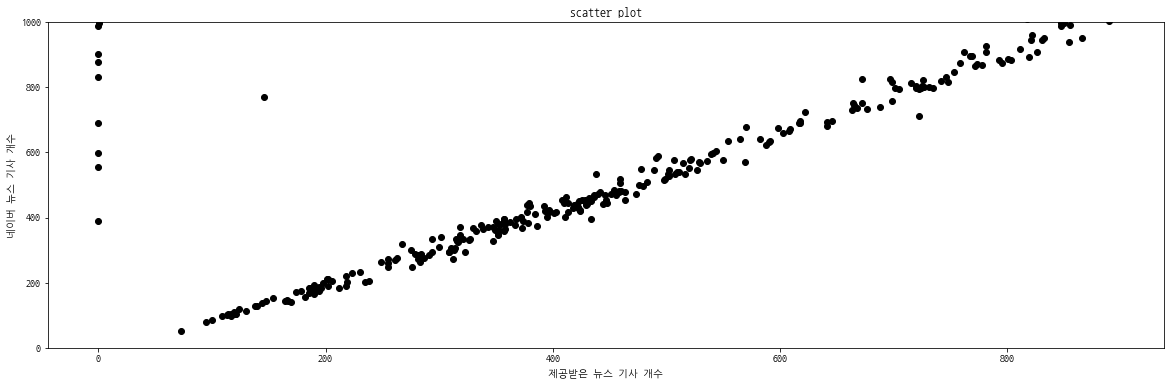

In [169]:
## 네이버 뉴스 기사 개수와 제공받은 SNS데이터(뉴스) correlation 확인
plt.figure(figsize=(20,6))
plt.scatter(df_total['sns'].values, df_total['naver'].values,c='k')
plt.ylim(0,1000)
plt.ylabel('네이버 뉴스 기사 개수')
plt.xlabel('제공받은 뉴스 기사 개수')
plt.title('scatter plot')
plt.show()

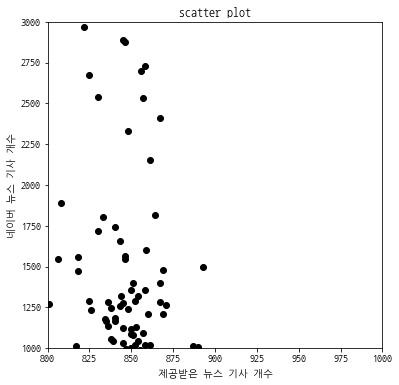

In [174]:
## 네이버 뉴스 기사 개수와 제공받은 SNS데이터(뉴스) correlation 확인
plt.figure(figsize=(6,6))
plt.scatter(df_total['sns'].values, df_total['naver'].values,c='k')
plt.ylim(1000,3000)
plt.xlim(800,1000)
plt.ylabel('네이버 뉴스 기사 개수')
plt.xlabel('제공받은 뉴스 기사 개수')
plt.title('scatter plot')
plt.show()

In [140]:
## sns가 0인 naver 뉴스 기사 갯수
null_index=[i for i in range(len(df_total)) if df_total.sns.iloc[i]==0 ]
df_total.naver.iloc[null_index]

DATE
2018-04-15     832
2018-05-29     902
2018-06-01     554
2019-01-09     691
2019-01-23    1698
2019-01-24    1489
2019-02-07    1320
2019-02-08     986
2019-02-16     390
2019-02-22    1815
2019-02-23     599
2019-03-08    2804
2019-03-09     876
2019-03-10    1311
2019-03-18    2712
2019-03-25    2297
Name: naver, dtype: int64

In [145]:
## 각각 percentage에 맞는 값을 sns데이터에서 찾아 빈 날짜에 집어넣기

for i in null_index:
    p=np.where(df_total.naver.sort_values()==df_total.naver.iloc[i])[0]/365*100
    df_total.sns.iloc[i]=int(np.percentile(pd.Series(df_total.sns.values).drop(0).drop(1).sort_values(), p)[0])

In [148]:
df_total.iloc[null_index]  # 결측 처리 완료!

,sns,naver
DATE,,
2018-04-15,714,832
2018-05-29,752,902
2018-06-01,474,554
2019-01-09,556,691
2019-01-23,852,1698
2019-01-24,850,1489
2019-02-07,846,1320
2019-02-08,801,986
2019-02-16,354,390


In [152]:
df_total = pd.DataFrame(df_total.sns)

In [153]:
df_total.to_csv('../data/innovation/sns/df_news.csv',index=False)